In [1]:
import altair as alt
import os
import pandas as pd
import scipy.io

from simulation_viz.import_simulation_data import import_ref_conc, gather_sim_data, get_met_rxn_names, get_time_series_quantiles
from simulation_viz.check_simulations import check_for_negative_concentrations, get_non_converging_models, remove_models
from simulation_viz.visualize_simulations import plot_ensemble, plot_model
from simulation_viz.visualize_simulations_interactive import plot_ensemble_interactive, plot_model_interactive

### Define path to the folder that contains the simulation results and model ensemble

In [2]:
raw_data_dir = '../io/output'

### Define the model name

In [3]:
model_name = 'toy_model'

### Define the simulation name

In [4]:
simulation_name = 'toy_model'

### Define number of models to be simulated

In [5]:
n_models = 5

### Define time points for the data interpolation

Since typically each simulation contains metabolite concentration values at different time points, we interpolate the concentrations (and also fluxes) so that all simulations have concentrations/fluxes for the same data points.

Besides, this leads to smaller dataframes and faster running times while keeping a good degree of accuracy.

In [6]:
order_of_magnitude = [-9, -8, -7, -6, -5, -4, -3, -2, -1]
time_points = [coefficient * 10 ** exponent for exponent in order_of_magnitude for coefficient in range(1, 10)]
time_points.extend([1])
time_points.insert(0, 0)

### Load and process data

In [7]:
met_names, rxn_names = get_met_rxn_names(raw_data_dir, model_name)

# import model ensemble
file_in = os.path.join(raw_data_dir, f'{model_name}.mat')
mat = scipy.io.loadmat(file_in, squeeze_me = False)

# get ALL metabolite names, also the constant ones
n_mets = len(mat['ensemble']['mets'][0][0])
all_met_names = [mat['ensemble']['mets'][0][0][met_i][0][0].replace('m_m_', '') for met_i in range(n_mets)]

# import reference concentrations
ref_conc_dic = import_ref_conc(mat, n_models, all_met_names)

# load simulation data file
simulation_name = f'{model_name}'
file_in = os.path.join(raw_data_dir, f'simulation_{simulation_name}.mat')
mat = scipy.io.loadmat(file_in, squeeze_me=False)

# import simulation data
conc, conc_interp, flux, flux_interp = gather_sim_data(mat, met_names, rxn_names, n_models, time_points,
                                                       save_concs=False, save_fluxes=False,
                                                       ref_conc_dic=ref_conc_dic)

total time: 0.08636212348937988
There were a total of 0 missing models out of 5.


### Check and filter out models

Check for negative concentrations

In [8]:
check_for_negative_concentrations(conc_interp, scaled=False)

All concentrations are above the treshold -1e-08 :)


Check for non converging models

In [9]:
non_converging_models = get_non_converging_models(conc_interp, n_models, met_names, rel_tol=5*10**-3)
non_converging_models

[]

Remove non-converging models

In [10]:
conc_interp_filtered, flux_interp_filtered = remove_models(conc_interp, flux_interp, non_converging_models)   

### Aggregate simulation results into median, 1st and 3rd quartile

In [11]:
quant_type = 'conc'
conc_interp_quantiles = get_time_series_quantiles(conc_interp_filtered, time_points, quant_type, met_names)
    
quant_type = 'flux'
flux_interp_quantiles = get_time_series_quantiles(flux_interp_filtered, time_points, quant_type, rxn_names)

### Plot results with matplotlib

#### Plot results for a given model

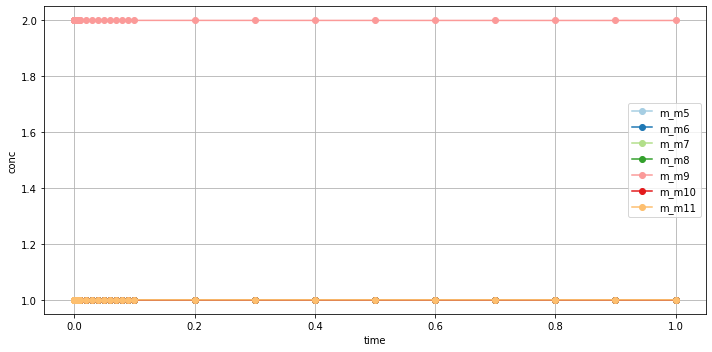

In [12]:
plot_model(conc, conc_interp, model_i=1, quant_type='conc',
           selected_data=met_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

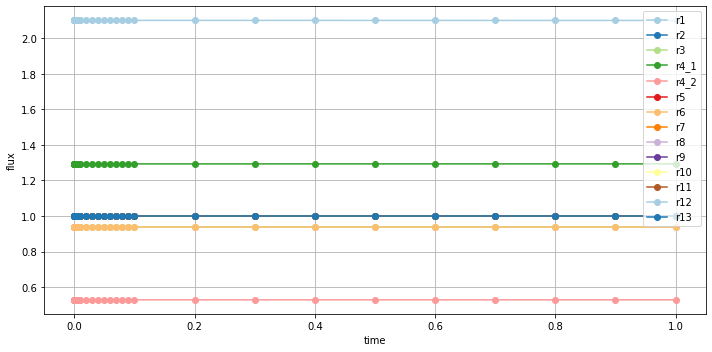

In [13]:
plot_model(flux, flux_interp, model_i=1, quant_type='flux',
           selected_data=rxn_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

#### Plot summarized results for whole ensemble

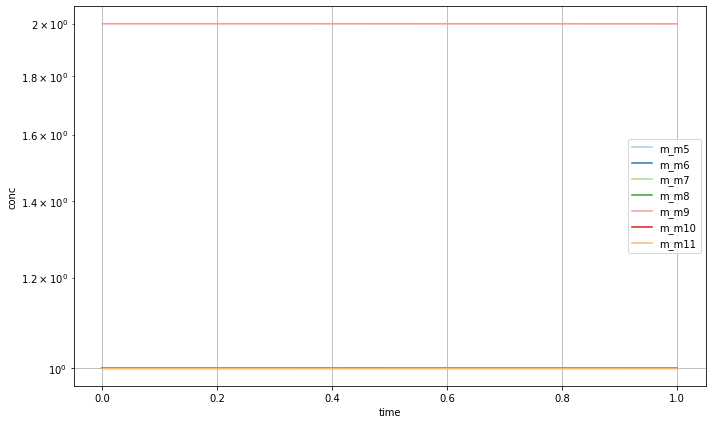

In [14]:
x_lim = None
y_lim = None

plot_ensemble(conc_interp_quantiles, quant_type='conc', selected_data=[met_names], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

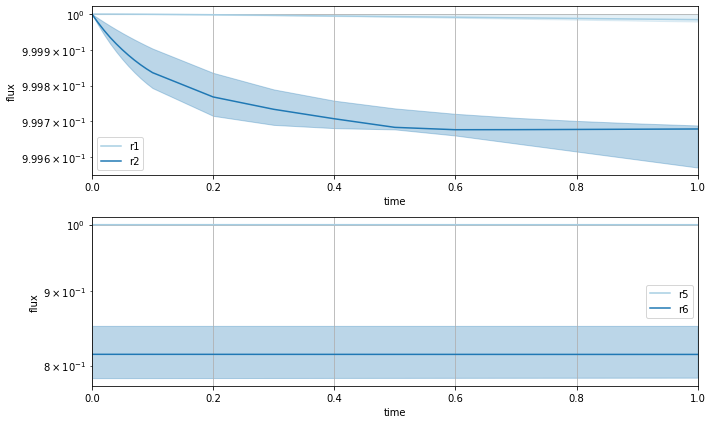

In [15]:
x_lim = [0, 1]
y_lim = None

plot_ensemble(flux_interp_quantiles, quant_type='flux', selected_data=[['r1', 'r2'], ['r5', 'r6']], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

### Plot results with altair

#### Plot results for a given model

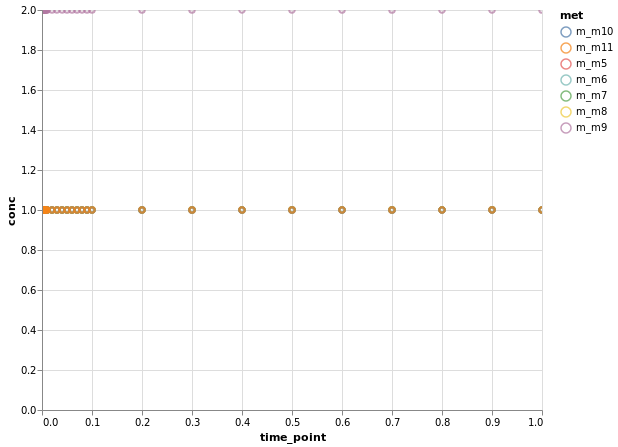

In [16]:
plot_model_interactive(conc, conc_interp, model_i=2, quant_type='conc',
                       selected_data=met_names, x_scale='linear',
                       y_scale='linear', x_lim=[0,1], y_lim=None)

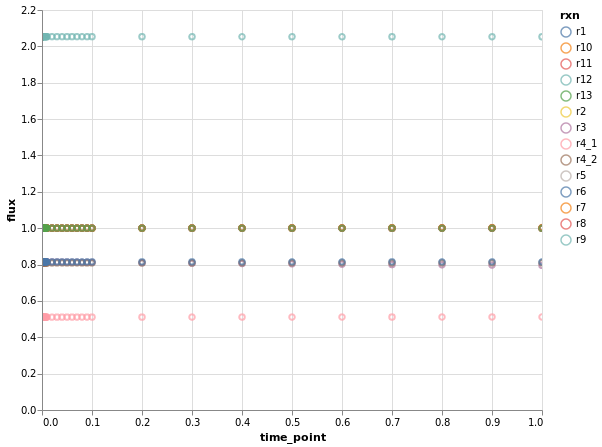

In [17]:
plot_model_interactive(flux, flux_interp, model_i=2, quant_type='flux',
                       selected_data=rxn_names, x_scale='linear',
                       y_scale='linear', x_lim=[0,1], y_lim=None)

#### Plot summarized results for whole ensemble

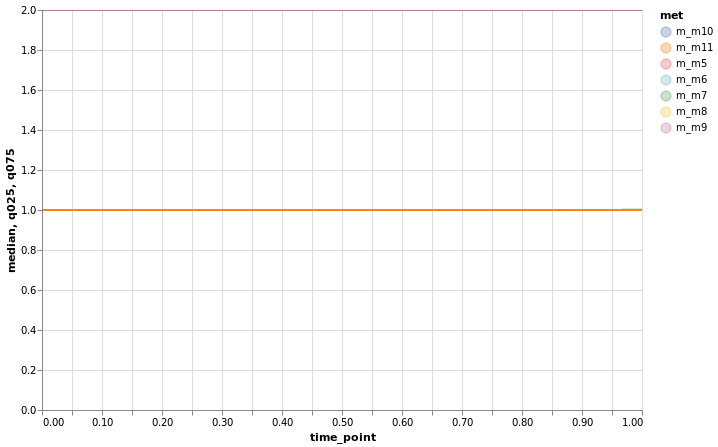

In [18]:
plot_ensemble_interactive(conc_interp_quantiles, quant_type='conc', selected_data=met_names, x_scale='linear',
                          y_scale='linear', x_lim=None, y_lim=None)

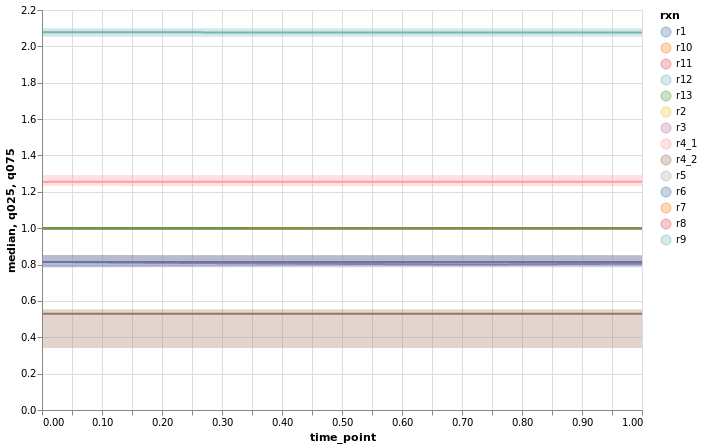

In [19]:
plot_ensemble_interactive(flux_interp_quantiles, quant_type='flux', selected_data=rxn_names, x_scale='linear',
                          y_scale='linear', x_lim=None, y_lim=None)